### prepare the dataset for the Kidson Types

In [1]:
%matplotlib inline

In [126]:
import sys, os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import h5py

# date and time stuff
from datetime import datetime, timedelta
from dateutil import parser, relativedelta

import xray
import seaborn as sns

In [127]:
import sys
sys.path.append('/Users/nicolasf/CODE/paleopy/')

In [128]:
from paleopy import markov

In [129]:
types = ['T', 'SW', 'TNW', 'TSW', 'H', 'HNW', 'W', 'HSE', 'HE', 'NE', 'HW', 'R']

In [130]:
dict_types = dict(zip(types,range(1,len(types)+14 )))
inv_dict_types = {v: k for k, v in dict_types.items()}

In [131]:
inv_dict_types

{1: 'T',
 2: 'SW',
 3: 'TNW',
 4: 'TSW',
 5: 'H',
 6: 'HNW',
 7: 'W',
 8: 'HSE',
 9: 'HE',
 10: 'NE',
 11: 'HW',
 12: 'R'}

In [132]:
%%writefile 
def select_season(data, season='DJF', complete=True, start = 1948, end = 2014, rm_leap=False):
    from calendar import monthrange
    """
    Select a season from data
    data must be a Pandas Series or DataFrame with a datetime index
    """
        
    seasons_params = {}
    seasons_params['DJF'] = (12,2)
    seasons_params['JFM'] = (1,3)
    seasons_params['FMA'] = (2,4)
    seasons_params['MAM'] = (3,5)
    seasons_params['AMJ'] = (4,6)
    seasons_params['MJJ'] = (5,7)
    seasons_params['JJA'] = (6,8)
    seasons_params['JAS'] = (7,9)
    seasons_params['ASO'] = (8,10)
    seasons_params['SON'] = (9,11)
    seasons_params['OND'] = (10,12)
    seasons_params['NDJ'] = (11,1)
    seasons_params['Warm Season (Dec. - May)'] = (12, 5)
    seasons_params['Cold Season (Jun. - Nov.)'] = (6, 11)
    seasons_params['Year (Jan. - Dec.)'] = (1, 12)
    seasons_params['Hydro. year (Jul. - Jun.)'] = (7, 6)    
        
    ### defines the selector 
    selector = ((data.index.month >= seasons_params[season][0]) | (data.index.month <= seasons_params[season][1]))
    
    ### selects
    data = data[selector]
    
    ### if complete == True, we only select COMPLETE seasons 
    data = data.truncate(before='%s-%s-1' % (start, seasons_params[season][0]),\
                   after='%s-%s-%s' % (end, seasons_params[season][1], monthrange(end,seasons_params[season][1])[1] ))
    
    if rm_leap: 
        data[(data.index.month == 2) & (data.index.day == 29)] = np.nan
        data.dropna(inplace=True)
    
    return data

In [133]:
def read_KTmat(fname="clusters_daily.mat", ystart=1948, yend=2014,\
              types = ['T', 'SW', 'TNW', 'TSW', 'H', 'HNW', 'W', 'HSE', 'HE', 'NE', 'HW', 'R']): 

    matfile = loadmat(os.path.join(os.environ['HOME'], 'data/KidsonTypes', fname), struct_as_record=False)

    clusters = matfile['clusters'][0,0]

    tclus = clusters.time

    # select period
    a = np.where( tclus[:,0] >= ystart)[0][0]
    z = np.where( tclus[:,0] <= yend)[0][-1] + 1 

    tclus = tclus[a:z,...]

    # i12 = np.where(tclus[:,-1] == 12)[0]
    # 
    # tclus = tclus[i12,...]

    ### ==============================================================================================================
    ### name of the regimes 
    name = clusters.name
    name = name[a:z,...]

    ### makes the names and types flat for lookup 
    names = []
    for nm in name:
        names.append(str(nm[0][0]))
    names = np.array(names)
    del(name)

    i = np.where(tclus[:,-1] == 0)[0]

    tclus = tclus[i,:]
    names = names[i,]
    K_Types = pd.DataFrame(names, index=[datetime(*d[:-1]) for d in tclus], columns=[['type']])
   
    dict_types = dict(zip(types,range(1,len(types)+14 )))
    inv_dict_types = {v: k for k, v in dict_types.items()}
    
    maptypes = lambda x: dict_types[x]
    
    K_Types['class'] =  K_Types.applymap(maptypes)
    
    return K_Types

In [134]:
K_Types = read_KTmat()

In [135]:
K_Types.head()

,type,class
1948-01-01,TNW,3
1948-01-02,NE,10
1948-01-03,NE,10
1948-01-04,NE,10
1948-01-05,NE,10


### selects the season

In [ ]:
season = 'DJF'

In [197]:
if os.path.exists('../outputs/simulations_Kidson_types.hdf5'): 
    os.remove('../outputs/simulations_Kidson_types.hdf5')

In [198]:
f = h5py.File('../outputs/simulations_Kidson_types.hdf5', mode='a')

for season in ['Warm Season (Dec. - May)']: 
    kseason = select_season(K_Types, start=1948, end=2014, season=season, rm_leap=False)
    probs = markov.get_probs(kseason['class'].values, np.arange(1, len(types)+1))
    probs = pd.Series(probs, index=types)
    classes, transition_matrix = markov.get_transition_probs(kseason['type'])
    probs = probs.reindex(classes)
    dict_classes, sim2D = markov.simulate_2D(classes, probs.values, transition_matrix, N=len(kseason), P=1000)
    probs = np.empty((len(classes), sim2D.shape[1]))
    for i in range(sim2D.shape[1]): 
        p = markov.get_probs(sim2D[:,i], np.arange(len(classes)))
        probs[:,i] = p
    f["/{}/probs".format(season)] = probs
    f["/{}/probs".format(season)].attrs['shape'] = '(class, simulation)'
    f["/{}/probs".format(season)].attrs['classes'] = ','.join(list(dict_classes.values()))

In [199]:
f.close()

In [218]:
f = h5py.File('../outputs/simulations_Kidson_types.hdf5', mode='r')

In [219]:
season = 'Warm Season (Dec. - May)'

In [213]:
sc = ['-',' ','(',')','.']

In [214]:
season_title = season

In [215]:
for c in sc: 
    season_title = season_title.replace(c,'_')

In [216]:
season_title

'Warm_Season__Dec____May_'

In [220]:
probs = f[season]['probs'].value * 100

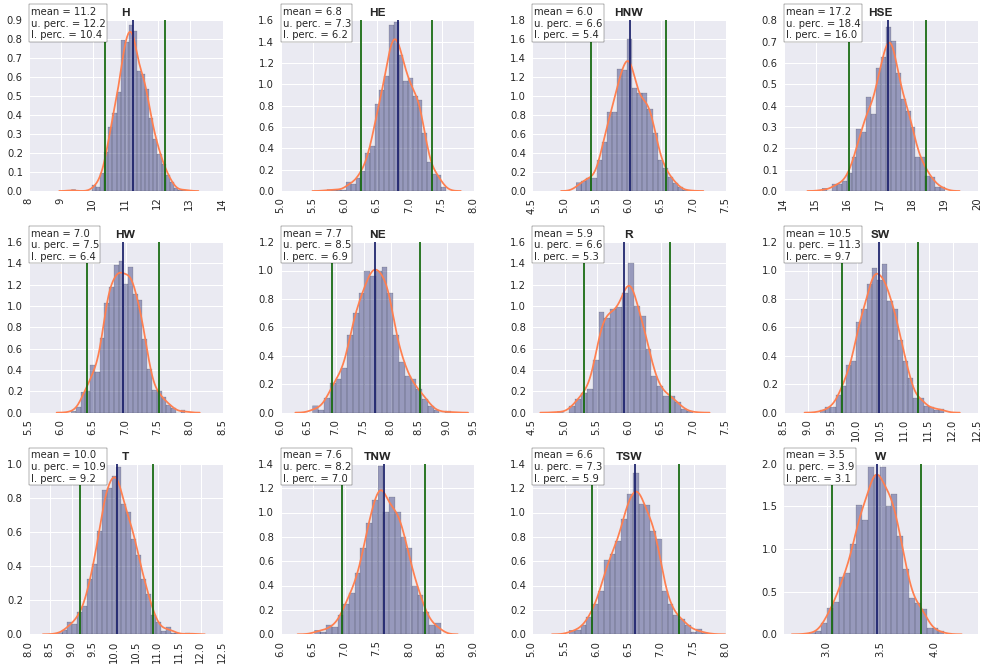

In [221]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(17,11))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()
for i in range(12): 
    ax = axes[i]
    p = probs[i,:]
    mp = p.mean()
    pu = np.percentile(p, 97.5)
    pl = np.percentile(p, 2.5)
    
    sns.distplot(p, ax=ax, color='#1B216B', kde_kws={'color':'coral'})
    ax.set_title(dict_classes[i],fontdict={'weight':'bold'})
    ax.axvline(mp, color='#1B216B')
    ax.axvline(pu, color='#13680D')
    ax.axvline(pl, color='#13680D')
    ax.text(0.01, 0.9, "mean = {:3.1f}\nu. perc. = {:3.1f}\nl. perc. = {:3.1f}".format(mp,pu,pl),\
           transform=ax.transAxes, bbox=dict(facecolor ='w'))
    [l.set_rotation(90) for l in ax.xaxis.get_ticklabels()]
fig.savefig('/Users/nicolasf/Desktop/distr_KT_simus_{}.png'.format(season_title), dpi=200)

In [222]:
f.close()